## Evaluation

In [50]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from model import Glow
from datasets import get_celeba
from torch.utils.data import DataLoader
from math import *

In [51]:
device = "cpu"
seed = 42
hidden_channels = 512
K = 32
L = 3
actnorm_scale = 1.0
flow_permutation = "invconv" 
flow_coupling = "affine" 
saved_model = "output/glow_checkpoint.pt"
LU_decomposed = False
learn_top = False
y_condition = False
image_shape = (64, 64, 3)
num_classes = 40
batch_size = 16
n_workers = 2

In [52]:
train_dataset, test_dataset = get_celeba(augment = False, dataroot = "CelebA")
train_loader = DataLoader(
                              train_dataset, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=n_workers, 
                              drop_last=True
                             )

In [53]:
model = Glow(image_shape, hidden_channels, K, L, actnorm_scale,
             flow_permutation, flow_coupling, LU_decomposed, num_classes,
             learn_top, y_condition)

model.load_state_dict(torch.load(saved_model, map_location=torch.device('cpu')))

model.set_actnorm_init()

model = model.to(device)

model = model.eval()



## Sample from model

In [54]:
def sample(model):
    with torch.no_grad():
        if y_condition:
            y = torch.eye(num_classes)
            y = y.repeat(batch_size // num_classes + 1)
            y = y[:32, :].to(device) # number hardcoded in model for now
        else:
            y = None

        images = model(y_onehot=y, temperature=0.5, reverse=True)

    return images.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 397.5, 331.5, -0.5)

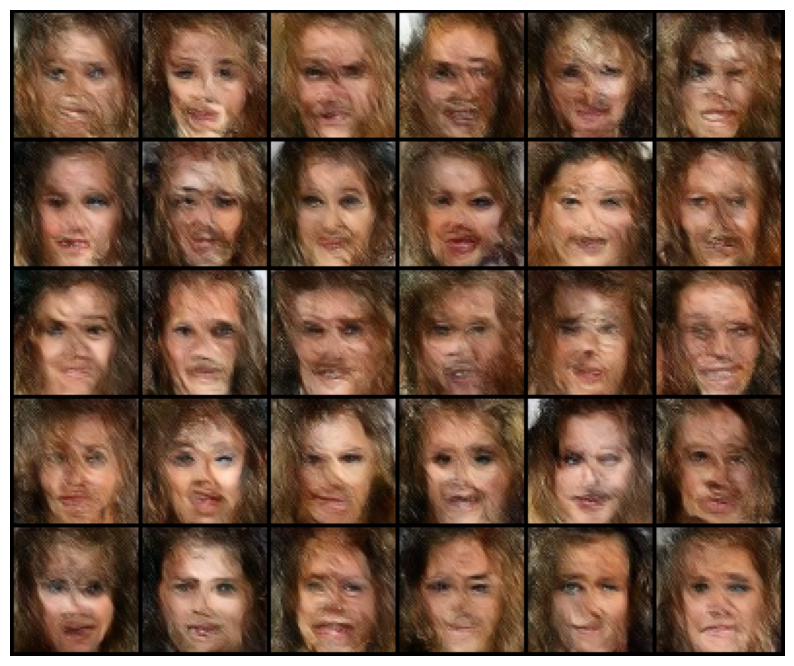

In [55]:
model = model.eval()

images = sample(model)
grid = make_grid(images[:30], nrow=6).permute(1,2,0)

plt.figure(figsize=(10,10))
plt.imshow(grid)
plt.axis('off')

## 

## Inpainting

In [56]:
def plot(x):
    grid = make_grid(x.cpu()[:30], nrow=6).permute(1,2,0)
    plt.figure(figsize=(10,10))
    plt.imshow(grid)
    plt.axis('off')

In [57]:
model = model.eval()


for i, batch in enumerate(train_loader):
    if i == 0:
        x, y = batch
        
    if i > 0:
        break

x = x.to(device)

with torch.no_grad():
    z_clean, _, _ = model(x, None)        
        
x[:, :, 24:42, 24:42] = 0   #apply deformation


with torch.no_grad():
    z_noise, _, _ = model(x, None)


In [58]:
x_clean = model(y_onehot = None, z = z_clean, temperature = 0, reverse = True)
x_noise = model(y_onehot = None, z = z_noise, temperature = 0, reverse = True)

z_p = z_noise * torch.exp(-0.5 * torch.square(z_noise))
z_rec = z_p / (z_p.std() * z_noise.std())

x_rec = model(y_onehot = None, z = z_rec, temperature = 0, reverse = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'image with noise')

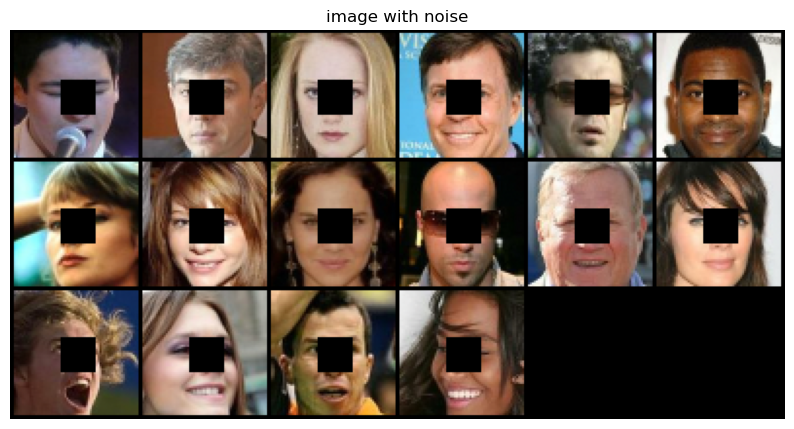

In [59]:
plot(x)
plt.title("image with noise")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'reconstruction from glow of the image without noise')

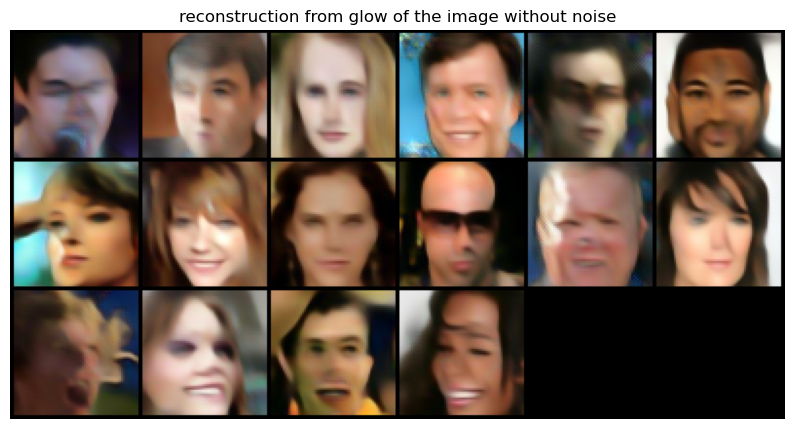

In [60]:
plot(x_clean)
plt.title("reconstruction from glow of the image without noise")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'reconstruction from glow of the noisy image')

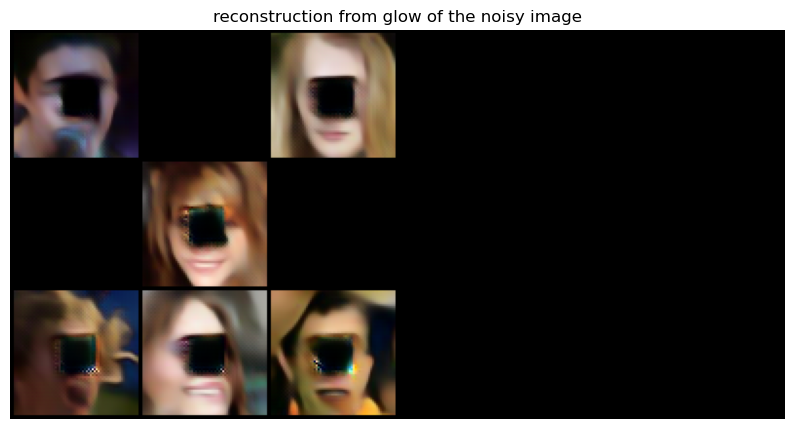

In [61]:
plot(x_noise)
plt.title("reconstruction from glow of the noisy image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'recovery of the noisy image via glow')

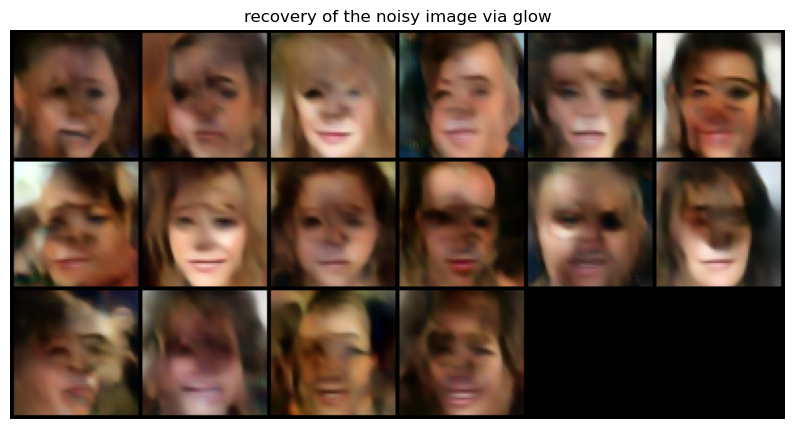

In [62]:
plot(x_rec)
plt.title("recovery of the noisy image via glow")